# Make a multipanel figure and run regressions with all the animal gut datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
from rich.progress import track
from statsmodels.formula.api import ols


### Import Godon et al dataset

In [2]:
crystals= pd.read_excel('.../Godon_data/Animal_Gut_Table_1.xlsx').rename(columns = {'Body mass (kg)':'body_mass_kg', 'Diversity':'inv_simpson'})
crystals.head()


,Name (common name),Phylogeny,body_mass_kg,Feeding type,Type of digestive tract,Size of animal husbandry group,inv_simpson,SD,Number of samples
0,Taeniopygia guttata (zebra finch),"Aves, Passeriformes",0.012,Granivorous,Hindgut colon,Large,1.2,0.1,3
1,Serinus canaria (canary),"Aves, Passeriformes",0.024,Granivorous,Hindgut colon,Large,1.6,0.5,2
2,Ramphocelus bresilius (brazilian tanager),"Aves, Passeriformes",0.035,Frugivorous,Hindgut colon,Small,3.4,0.4,4
3,Melopsittacus undulatus (budgerigar),"Aves, Psittaciformes",0.040,Granivorous,Hindgut colon,Large,1.9,3.0,3
4,Ploceus cucullatus (village weaver),"Aves, Passeriformes",0.040,Granivorous,Hindgut colon,Small,2.3,0.0,2


### Import Song and Groussin datasets

In [3]:
# We generated this CSV in the vertebrate diversity notebook
all_16S = pd.read_csv('.../output/Song_Groussin_Diversity.csv')
all_16S.head()

,Unnamed: 0,SampleID,simpson,body_mass_kg,dataset,inv_simpson
0,0,Armadillo,0.991125,1.20,Groussin et al,112.679696
1,1,BaboonSTL,0.954364,18.00,Groussin et al,21.912337
2,2,BigHornSD,0.996792,67.13,Groussin et al,311.698950
3,3,BlackBr2,0.465413,175.00,Groussin et al,1.870604
4,4,BlackLemur,0.870901,2.04,Groussin et al,7.746001


In [4]:
# Add color column so I can assign them when I plot
all_16S['color'] = all_16S.dataset.apply(lambda x: '#AA4499' if x == 'Groussin et al' else '#88CCEE')
all_16S.head()

,Unnamed: 0,SampleID,simpson,body_mass_kg,dataset,inv_simpson,color
0,0,Armadillo,0.991125,1.20,Groussin et al,112.679696,#AA4499
1,1,BaboonSTL,0.954364,18.00,Groussin et al,21.912337,#AA4499
2,2,BigHornSD,0.996792,67.13,Groussin et al,311.698950,#AA4499
3,3,BlackBr2,0.465413,175.00,Groussin et al,1.870604,#AA4499
4,4,BlackLemur,0.870901,2.04,Groussin et al,7.746001,#AA4499


### Log transform data in to a different df called 'toplot'

In [5]:
all_toplot = all_16S[['SampleID', 'inv_simpson', 'body_mass_kg', 'color', 'dataset']].copy()
features = ['inv_simpson', 'body_mass_kg']
all_toplot[features] = all_toplot[features].apply(lambda x: np.log(x))

# Drop rows with no data
all_toplot = all_toplot.dropna()
all_toplot.head()

,SampleID,inv_simpson,body_mass_kg,color,dataset
0,Armadillo,4.724549,0.182322,#AA4499,Groussin et al
1,BaboonSTL,3.087050,2.890372,#AA4499,Groussin et al
2,BigHornSD,5.742038,4.206631,#AA4499,Groussin et al
3,BlackBr2,0.626261,5.164786,#AA4499,Groussin et al
4,BlackLemur,2.047177,0.712950,#AA4499,Groussin et al


In [6]:
c_toplot = crystals[['Name (common name)', 'body_mass_kg', 'inv_simpson']].copy()
features = ['body_mass_kg', 'inv_simpson']
c_toplot[features] = c_toplot[features].apply(lambda x: np.log(x))

# Drop rows with no data
c_toplot = c_toplot.dropna()
c_toplot.head()

,Name (common name),body_mass_kg,inv_simpson
0,Taeniopygia guttata (zebra finch),-4.422849,0.182322
1,Serinus canaria (canary),-3.729701,0.470004
2,Ramphocelus bresilius (brazilian tanager),-3.352407,1.223775
3,Melopsittacus undulatus (budgerigar),-3.218876,0.641854
4,Ploceus cucullatus (village weaver),-3.218876,0.832909


### Do ols with log transformed data, so I can display certain values on my plot later

In [7]:
def get_results(feature):
    formula = f"{feature} ~ body_mass_kg"
    fitted = ols(formula, data=df).fit()
    return pd.DataFrame({
        "feature": feature,
        "beta": fitted.params["body_mass_kg"],
        "t_statistic": fitted.tvalues["body_mass_kg"],
        "p": fitted.pvalues["body_mass_kg"],
        "n": fitted.nobs, 
        "rsquared":fitted.rsquared
        }, index=[feature])

args = ['inv_simpson']
df = all_toplot
results = map(get_results, track(args))
results = list(results)
tests = pd.concat(results)
tests

Output()

,feature,beta,t_statistic,p,n,rsquared
inv_simpson,inv_simpson,0.235428,36.234293,2.141585e-203,1403.0,0.483773


In [8]:
# Save p and r squared for later 
p1 = tests.iloc[0,3]
r1 = tests.iloc[0,5]
print(p1, r1)

2.141584656814487e-203 0.4837733034588967


In [9]:
df = c_toplot
results = map(get_results, track(args))
results = list(results)
tests = pd.concat(results)

tests

Output()

,feature,beta,t_statistic,p,n,rsquared
inv_simpson,inv_simpson,0.101589,9.397567,1.831117e-14,80.0,0.531008


In [10]:
# save p and r squared for later
p2 = tests.iloc[0,3]
r2 = tests.iloc[0,5]

print(p2, r2)

1.8311170422309435e-14 0.5310083766644857


In [11]:
all_16S.head()

,Unnamed: 0,SampleID,simpson,body_mass_kg,dataset,inv_simpson,color
0,0,Armadillo,0.991125,1.20,Groussin et al,112.679696,#AA4499
1,1,BaboonSTL,0.954364,18.00,Groussin et al,21.912337,#AA4499
2,2,BigHornSD,0.996792,67.13,Groussin et al,311.698950,#AA4499
3,3,BlackBr2,0.465413,175.00,Groussin et al,1.870604,#AA4499
4,4,BlackLemur,0.870901,2.04,Groussin et al,7.746001,#AA4499


In [12]:
all_toplot.head()

,SampleID,inv_simpson,body_mass_kg,color,dataset
0,Armadillo,4.724549,0.182322,#AA4499,Groussin et al
1,BaboonSTL,3.087050,2.890372,#AA4499,Groussin et al
2,BigHornSD,5.742038,4.206631,#AA4499,Groussin et al
3,BlackBr2,0.626261,5.164786,#AA4499,Groussin et al
4,BlackLemur,2.047177,0.712950,#AA4499,Groussin et al


In [13]:
c_toplot.head()

,Name (common name),body_mass_kg,inv_simpson
0,Taeniopygia guttata (zebra finch),-4.422849,0.182322
1,Serinus canaria (canary),-3.729701,0.470004
2,Ramphocelus bresilius (brazilian tanager),-3.352407,1.223775
3,Melopsittacus undulatus (budgerigar),-3.218876,0.641854
4,Ploceus cucullatus (village weaver),-3.218876,0.832909


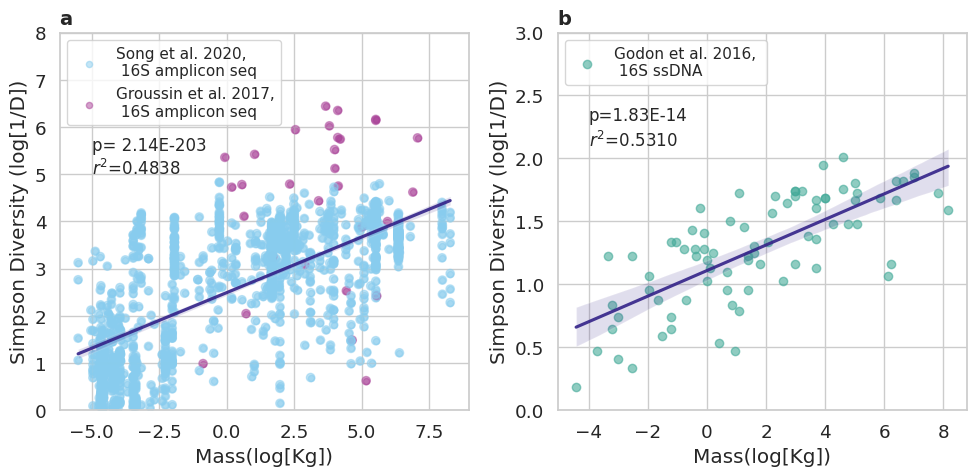

In [15]:
sns.set_theme(style='whitegrid',font_scale=1.2)
fig, axs = plt.subplots(1,2, figsize = (10,5))

x='body_mass_kg'
y= 'inv_simpson'

color_label = {'#88CCEE':'Groussin et al. 2017,\n 16S amplicon seq', '#AA4499':'Song et al. 2020,\n 16S amplicon seq'}
colors = list(all_toplot['color'].unique())
labels = [color_label[x] for x in all_toplot['color'].unique()]

sns.regplot(data = all_toplot, ax = axs[0],
            x=x, y=y,scatter_kws={'c':all_toplot['color'], 'color':None, 'alpha':0.5, 'zorder':1},\
            line_kws={'color':'#332288', 'alpha':0.9})

index =0
for i, grp in all_toplot.groupby(['color']):
    grp.plot(kind = 'scatter', x=x, y=y, c=i, ax = axs[0], label = labels[index], zorder=0, alpha = 0.5)
    index +=1

axs[0].text(-5,5.5, f'p= {p1:.2E}', fontsize = 12)
axs[0].text(-5,5, f'$r^2$={r1:.4f}', fontsize=12)
axs[0].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson Diversity (log[1/D])')
axs[0].set_ylim([0,8])
axs[0].set_title('a', loc='left', fontweight='bold', fontsize=14) 

sns.regplot(data = c_toplot, x=x, y=y, ax = axs[1],\
           scatter_kws={'alpha':0.6, 'color':'#44AA99'}, line_kws={'color':'#332288', 'alpha':0.9})
axs[1].set(xlabel='Mass(log[Kg])', ylabel= 'Simpson Diversity (log[1/D])')
axs[1].set_ylim([0,3])

axs[1].text(-4,2.3, f"p={p2:.2E}", fontsize=12)
axs[1].text(-4,2.1, f'$r^2$={r2:.4f}', fontsize=12)

axs[1].set_title('b', loc='left', fontsize=14, fontweight='bold')


axs[0].legend(loc='upper left', fontsize=11)
axs[1].legend(['Godon et al. 2016, \n 16S ssDNA '],loc='upper left', fontsize=11)


fig.tight_layout()



In [16]:
fig.savefig('.../output/all_animal_guts.png')